In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42 # For shuffling the data when creating the training dataset

# Paths

In [2]:
dataset = 'model/hand_history_classifier/hand_history.csv'
model_save_path = 'model/hand_history_classifier/hand_history_classifier.hdf5'

# Number of classes / labels 

In [3]:
NUM_CLASSES = 6 # Change according to how many labels

# Number of frames 

In [4]:
TIME_STEPS = 16 # Number of frames
DIMENSION = 2

# Read datasets

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1))) # Position of hand that were saved in the dataset 
print(X_dataset)

[[ 0.          0.         -0.02604167 ... -0.17037037  0.04479166
  -0.22037037]
 [ 0.          0.         -0.04895834 ... -0.18148148  0.03229167
  -0.22222222]
 [ 0.          0.         -0.05729167 ... -0.22037037 -0.00625
  -0.26481482]
 ...
 [ 0.          0.         -0.04583333 ...  0.08703703 -0.03645833
   0.08888889]
 [ 0.          0.         -0.04583333 ...  0.08888889 -0.03645833
   0.09259259]
 [ 0.          0.         -0.046875   ...  0.08703703 -0.034375
   0.08703703]]


In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0)) #Labels 0-4 (Left, Right, Throttle, Brake, Toggle Reverse)
print(y_dataset)

[0 0 0 ... 4 4 4]


In [7]:
# Split dataset into random train and test subsets 
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED) 
# train_size=0.75: 75% of dataset is for training
# random_state=RANDOM_SEED: Shuffle dataset 

In [8]:
use_lstm = True
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # InputLayer: Layer to be used as an entry point into a Network (a graph of layers)
    # Must have same shape as training data
    # E.g If you have 30 images of 50x50 pixels in RGB(3 channels), the shape of your input data is (30,50,50,3). 
    # In this case, input shape is (32, ), as there are 32 values in each row in the dataset
    # Dropout: Randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
    # LSTM: Long short-term memory network. Capable of learning long-term dependencies, especially in sequence prediction problems
    # LSTM(16, input_shape=[TIME_STEPS, DIMENSION]), input to every LSTM layer must be three-dimensional
    # 16: How many samples in each batch during training and testing
    # input_shape: TIME_STEPS defines number of characters you want the network to memorize
    # input_shape: DIMENSION defines number of dimensions to feed at each time step
    # e.g A signal such as accelerometer measurements is 3D thus has X, Y, and Z signal. Thus, 3 features are sent at each time step for each sample
    # Dense: Every input neuron of preceding layers go to every single neuron of the dense layer
    # 10: Defines the size of the output from the dense layer
    # Dense: NUM_CLASSES as each neuron represents one class/label
    # Dense: softmax is used to only output the class with the highest probability
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 16, 2)             0         
                                                                 
 dropout (Dropout)           (None, 16, 2)             0         
                                                                 
 lstm (LSTM)                 (None, 16)                1216      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,452
Trainable params: 1,452
Non-trainabl

In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) #Save model regularly during training. Saves model checkpoints at regular intervals.
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1) #Stop training when it stops improving, prevents overfitting

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000, # Number of rounds the model will train for
    batch_size=128, # Number of samples to use from dataset for one epoch
    validation_data=(X_test, y_test), # Test model on data that was not used for training
    callbacks=[cp_callback, es_callback] # Specify what callbacks to use for the model when training
)

Epoch 1/1000
1/7 [===>..........................] - ETA: 7s - loss: 1.7827 - accuracy: 0.2188
Epoch 1: saving model to model/hand_history_classifier\hand_history_classifier.hdf5
7/7 [==============================] - 2s 67ms/step - loss: 1.7823 - accuracy: 0.2234 - val_loss: 1.7791 - val_accuracy: 0.2645
Epoch 2/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.7802 - accuracy: 0.2344
Epoch 2: saving model to model/hand_history_classifier\hand_history_classifier.hdf5
7/7 [==============================] - 0s 9ms/step - loss: 1.7745 - accuracy: 0.2452 - val_loss: 1.7714 - val_accuracy: 0.2428
Epoch 3/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.7640 - accuracy: 0.2422
Epoch 3: saving model to model/hand_history_classifier\hand_history_classifier.hdf5
7/7 [==============================] - 0s 9ms/step - loss: 1.7676 - accuracy: 0.2331 - val_loss: 1.7624 - val_accuracy: 0.2210
Epoch 4/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.7658 - accurac

In [13]:
# Load the saved model
model = tf.keras.models.load_model(model_save_path) 

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 288ms/step
[6.0187601e-03 6.2619144e-04 3.6097736e-05 9.7535306e-01 1.3425123e-03
 1.6623298e-02]
3


# Confusion Matrix

9/9 [==============================] - 0s 1ms/step


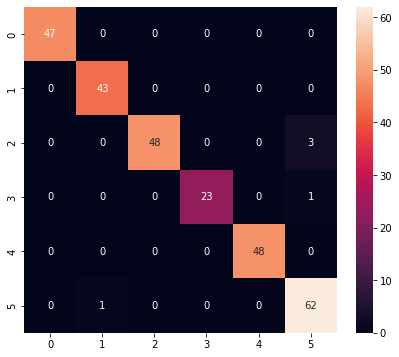

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       0.98      1.00      0.99        43
           2       1.00      0.94      0.97        51
           3       1.00      0.96      0.98        24
           4       1.00      1.00      1.00        48
           5       0.94      0.98      0.96        63

    accuracy                           0.98       276
   macro avg       0.99      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to Tensorflow Lite model

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [17]:
tflite_save_path = 'model/hand_history_classifier/hand_history_classifier.tflite'

In [18]:
# Transform model into TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ezs03\AppData\Local\Temp\tmp6fyu273i\assets


INFO:tensorflow:Assets written to: C:\Users\ezs03\AppData\Local\Temp\tmp6fyu273i\assets


13552

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I/O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 999 Âµs


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.8343424e-03 7.2973245e-04 3.8231636e-05 9.7402579e-01 1.2920928e-03
 1.8079845e-02]
3
